In [1]:
import os
import json
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from auto_encoder_hyperparameters import build_autoencoder
import datetime
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model


Found 176 images belonging to 1 classes.


C:\Users\haard\AppData\Local\Temp\ipykernel_54812\2766980533.py:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.engine.hyperparameters import HyperParameters


Found 43 images belonging to 1 classes.
Found 132 images belonging to 6 classes.
Initializing tuner...
Reloading Tuner from autoencoder_tuning\autoencoder_tuning\tuner0.json
Starting hyperparameter search...

The hyperparameter search is complete. The optimal hyperparameters are:
- Encoder layer 1 filters: 32
- Encoder layer 2 filters: 64
- Encoder layer 3 filters: 128
- Decoder layer 1 filters: 128
- Decoder layer 2 filters: 64
- Decoder layer 3 filters: 32
- Learning rate: 0.001
- Batch size: 64
- Epochs: 10
- Optimizer: Adam

Saved best hyperparameters to file to best_hyperparameters.json


In [2]:

# ------------------ DATA PREPROCESSING AND SETUP ------------------ #

# Set Paths
dataset_dir = 'capsule/capsule/'
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

# Preprocessing parameters
img_height, img_width = 256, 256 # adjust this to your input image size
batch_size = 64 # was 32 - use range of 16, 32, 64, 128, 256, 512, 1024

# Setup TensorBoard
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Initialise the TensorBoard callback object
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Training Data Generators
# In this case only 'good' images for training are needed
print("Train Dataset:")
train_datatgen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datatgen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='input', # 'input' because the output is the same as the input 
    subset='training', # specify this is training data
    color_mode='rgb',
    shuffle=True
)

print("Validation Dataset:")
validation_generator = train_datatgen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='input', # 'input' because the output is the same as the input
    subset='validation', # specify this is validation data
    color_mode='rgb',
    shuffle=True
)

# Test Data Generators (All images for testing)
print("Test Dataset:")
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None, # No labels for test data
    color_mode='rgb',
    shuffle=False
)


Train Dataset:
Found 176 images belonging to 1 classes.


Validation Dataset:
Found 43 images belonging to 1 classes.
Test Dataset:
Found 132 images belonging to 6 classes.


[LOAD] Model loaded from: saved_models/final_best_autoencoder.h5
Model Summary:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                               

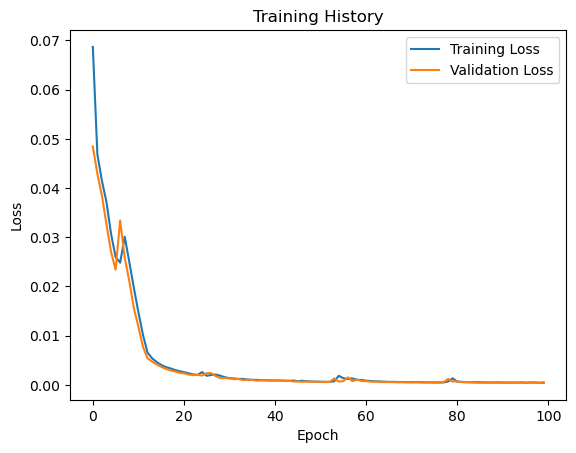

[SAVE] Training history plot saved to: training_history.png


In [4]:

# --------------------------- MODEL DEFINITION --------------------------- #

TRAIN_MODEL = False

if TRAIN_MODEL:
    # Create a ModelCheckpoint callback that saves the model's weights
    num_epochs = 100  # Adjust based on your needs
    checkpoint_path = f'saved_models/model_checkpoints/model-{num_epochs:02d}-.h5'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=False,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    )

    # Initialise the EarlyStopping callback
    early_stopping_callback = EarlyStopping(
        monitor='val_loss',  # Monitor the validation loss
        patience=15,          # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
    )

    # Load the hyperparameters from the JSON file
    with open('best_hyperparameters.json', 'r') as f:
        best_hps_dict = json.load(f)

    # print the hyperparameters
    print("Best Hyperparameters loaded from best_hyperparameters.json file:")
    print(best_hps_dict)

    # Convert the dictionary back to a HyperParameters object
    best_hps = HyperParameters.from_config(best_hps_dict)

    # Now you can use best_hps to rebuild the model with the best hyperparameters
    best_autoencoder = build_autoencoder(best_hps)

    print("Model Summary:")
    best_autoencoder.summary()

    print("\n\nModel Ready for Training.")

    # Continue with model training as before
    best_history = best_autoencoder.fit(
        train_generator,
        epochs=num_epochs,  # Adjust based on your needs
        validation_data=validation_generator,
        callbacks=[tensorboard_callback, early_stopping_callback, model_checkpoint_callback]
    )

    # Save the trained model
    best_autoencoder.save('saved_models/final_best_autoencoder.h5')

    # Save the training history to a JSON file
    with open('best_history.json', 'w') as f:
        json.dump(best_history.history, f)

    print("[SAVE] Model saved to: saved_models/final_best_autoencoder.h5")

else:
    # Load the trained model
    best_autoencoder = load_model('saved_models/final_best_autoencoder.h5')

    print("[LOAD] Model loaded from: saved_models/final_best_autoencoder.h5")
    print("Model Summary:")
    best_autoencoder.summary()

    # Load the training history from the JSON file
    with open('best_history.json', 'r') as f:
        best_history = json.load(f)

    # Print the training history
    print("Training History:")
    print(best_history)

    # Plot the training history
    plt.figure()
    plt.plot(best_history['loss'], label='Training Loss')
    plt.plot(best_history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training History')
    plt.legend(['Training Loss', 'Validation Loss'])
    fg_hist = plt.gcf()
    plt.show()

    # save the plot to a PNG file
    fg_hist.savefig('training_history.png')
    print(f'[SAVE] Training history plot saved to: training_history.png')


1/1 [==============================] - 1s 820ms/step
Sahpe of test_images: 132
Sahpe of reconstructed_images: 132


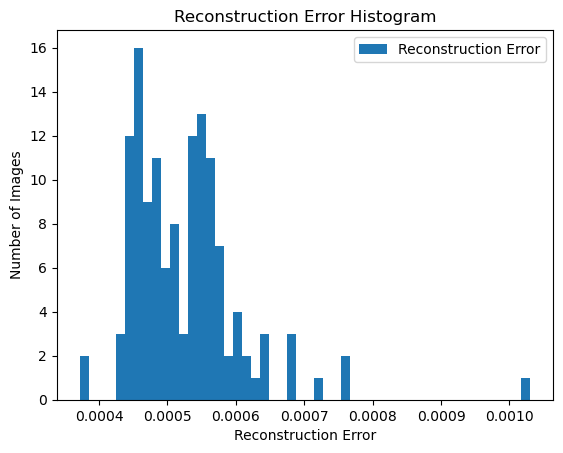

[SAVE] Reconstruction error plot saved to: reconstruction_error.png
[SAVE] Reconstruction error saved to: reconstruction_error.csv


In [5]:

# --------------------------- MODEL PREDICTION --------------------------- #
# Assuming test_generator is your test dataset generator
# test_images, _ = next(test_generator)  # Get a batch of test images
# test_images = next(test_generator)  # Get a batch of test images

test_images = []
reconstructed_images = []
for _ in range(len(test_generator)):
    batch_images = next(test_generator)
    test_images.extend(batch_images)

    batch_reconstructed = best_autoencoder.predict(batch_images)
    reconstructed_images.extend(batch_reconstructed)

reconstructed_images = np.array(reconstructed_images)

print(f"Sahpe of test_images: {len(test_images)}")
print(f"Sahpe of reconstructed_images: {len(reconstructed_images)}")

# # batch_index = 0  # If you have called next(test_generator) once
# batch_index = test_generator.batch_index  # If you have called next(test_generator) more than once
# print(f"Batch_index: {batch_index}")

# # get a list of test filenames for the batch
# test_filenames_batch = test_generator.filenames[batch_index * test_generator.batch_size : (batch_index + 1) * test_generator.batch_size]

# # test_filenames_batch = test_generator.filenames[batch_index * test_generator.batch_size : (batch_index) * test_generator.batch_size]
# print("Test filenames batch:")
# print(test_filenames_batch)

# print(f"Test images batch size: {test_generator.batch_size}")  # Check the batch size


# print(f"Shape of test_images: {test_images.shape}")

# reconstructed_images = best_autoencoder.predict(test_images)

# print(f"Shape of reconstructed_images: {reconstructed_images.shape}")

# Calculate reconstruction error
reconstruction_error = np.mean(np.square(test_images - reconstructed_images), axis=(1, 2, 3))

# Plot the reconstruction error
plt.hist(reconstruction_error, bins=50)
plt.xlabel('Reconstruction Error')
plt.ylabel('Number of Images')
plt.title('Reconstruction Error Histogram')
plt.legend(['Reconstruction Error'])
fg1 = plt.gcf()
plt.show()

# save the plot to a PNG file
fg1.savefig('reconstruction_error.png')
print(f'[SAVE] Reconstruction error plot saved to: reconstruction_error.png')

# save the reconstruction error to a CSV file
np.savetxt('reconstruction_error.csv', reconstruction_error, delimiter=',')
print(f'[SAVE] Reconstruction error saved to: reconstruction_error.csv')


In [6]:

# --------------------------- MODEL EVALUATION --------------------------- #
from sklearn.metrics import roc_auc_score, roc_curve
import cv2
import numpy as np
import os


# iterate through each directory and get the list of filenames in each directory in test_dir
# get all the directories in test_dir
test_images_directories = os.listdir(test_dir)
print("dirs in test_dir:", test_images_directories)

test_images_local_paths = []
for directory in test_images_directories:
    # get the list of filenames in each directory
    filenames = os.listdir(os.path.join(test_dir, directory))

    # append the filenames to the list of test images paths
    for filename in filenames:
        # test_images_local_paths.append(os.path.join(os.path.join(test_dir, directory), filename))    
        test_images_local_paths.append(os.path.join(directory, filename))    

print("test_images_filenames:", test_images_local_paths)
print("Total test images found: ", len(test_images_local_paths))


dirs in test_dir: ['crack', 'faulty_imprint', 'good', 'poke', 'scratch', 'squeeze']
test_images_filenames: ['crack\\000.png', 'crack\\001.png', 'crack\\002.png', 'crack\\003.png', 'crack\\004.png', 'crack\\005.png', 'crack\\006.png', 'crack\\007.png', 'crack\\008.png', 'crack\\009.png', 'crack\\010.png', 'crack\\011.png', 'crack\\012.png', 'crack\\013.png', 'crack\\014.png', 'crack\\015.png', 'crack\\016.png', 'crack\\017.png', 'crack\\018.png', 'crack\\019.png', 'crack\\020.png', 'crack\\021.png', 'crack\\022.png', 'faulty_imprint\\000.png', 'faulty_imprint\\001.png', 'faulty_imprint\\002.png', 'faulty_imprint\\003.png', 'faulty_imprint\\004.png', 'faulty_imprint\\005.png', 'faulty_imprint\\006.png', 'faulty_imprint\\007.png', 'faulty_imprint\\008.png', 'faulty_imprint\\009.png', 'faulty_imprint\\010.png', 'faulty_imprint\\011.png', 'faulty_imprint\\012.png', 'faulty_imprint\\013.png', 'faulty_imprint\\014.png', 'faulty_imprint\\015.png', 'faulty_imprint\\016.png', 'faulty_imprint\\01

In [7]:
# Function to load ground truth masks
def load_ground_truth_masks(ground_truth_dir, test_images_filenames, img_height, img_width):
    ground_truth_masks = []
    for filename in test_images_filenames:
        # Construct the path to the ground truth mask
        mask_path = os.path.join(ground_truth_dir, filename)
        # Load the mask image
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if mask is None:
            print(f'Could not read mask from {mask_path}.\nAssuming a clean ground truth with no anomalies for {filename}')
            mask = np.zeros((img_height, img_width), dtype=np.uint8)
        
        # Resize the mask to match the model input size
        mask = cv2.resize(mask, (img_height, img_width))
        # Binarize the mask: pixels with a value will be set to 1, the rest to 0
        _, binary_mask = cv2.threshold(mask, 1, 1, cv2.THRESH_BINARY)
        ground_truth_masks.append(binary_mask)

    # Convert the list to a numpy array and return
    return np.stack(ground_truth_masks)

# Define the path to your ground truth directory
ground_truth_dir = 'capsule/capsule/ground_truth'

# Define the image size
img_height, img_width = 256, 256  # The size to which images are resized

# Load the ground truth masks
ground_truth_masks_local_paths = []
for filepath in test_images_local_paths:
    # Ground truth masks follow the same directory structure as the test images but the names have "_mask" appended at the end
    # every dirs exists except good
    ground_truth_masks_local_paths.append(filepath.replace('.png', '_mask.png'))
    
    # if 'good' not in filepath:
    #     ground_truth_masks_local_paths.append(filepath.replace('.png', '_mask.png'))

print(len(ground_truth_masks_local_paths))
print(len(test_images_local_paths))

assert len(ground_truth_masks_local_paths) == len(test_images_local_paths), "Number of ground truth masks does not match number of test images"

ground_truth_masks = load_ground_truth_masks(ground_truth_dir, ground_truth_masks_local_paths, img_height, img_width)

132
132
Could not read mask from capsule/capsule/ground_truth\good\000_mask.png.
Assuming a clean ground truth with no anomalies for good\000_mask.png
Could not read mask from capsule/capsule/ground_truth\good\001_mask.png.
Assuming a clean ground truth with no anomalies for good\001_mask.png
Could not read mask from capsule/capsule/ground_truth\good\002_mask.png.
Assuming a clean ground truth with no anomalies for good\002_mask.png
Could not read mask from capsule/capsule/ground_truth\good\003_mask.png.
Assuming a clean ground truth with no anomalies for good\003_mask.png
Could not read mask from capsule/capsule/ground_truth\good\004_mask.png.
Assuming a clean ground truth with no anomalies for good\004_mask.png
Could not read mask from capsule/capsule/ground_truth\good\005_mask.png.
Assuming a clean ground truth with no anomalies for good\005_mask.png
Could not read mask from capsule/capsule/ground_truth\good\006_mask.png.
Assuming a clean ground truth with no anomalies for good\006_

Shape of ground_truth_masks: (132, 256, 256)
Shape of ground_truth_masks_flatten: (8650752,)
Shape of reconstructed_images: (132, 256, 256, 3)
Shape of reconstructed_images: (132, 256, 256)
Shape of reconstructed_images_flatten: (8650752,)
Pixel-wise ROC-AUC: 0.14668139263513827


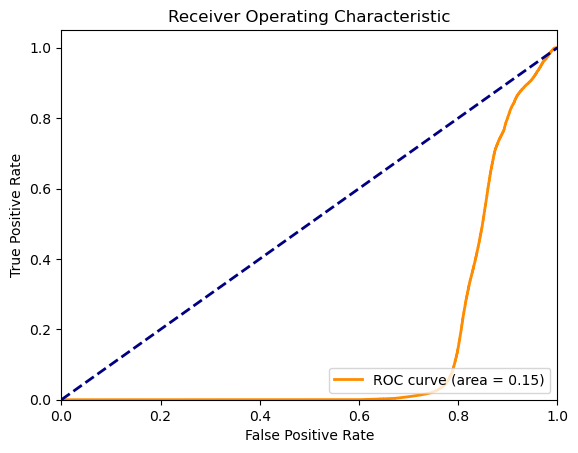

[SAVE] ROC curve plot saved to: roc_curve.png
[SAVE] ROC curve saved to: roc_curve.csv


In [8]:


# Flatten the images and ground truth masks to 1D arrays for ROC calculation
print(f"Shape of ground_truth_masks: {ground_truth_masks.shape}")
ground_truth_masks_flatten = ground_truth_masks.reshape(-1)
print(f"Shape of ground_truth_masks_flatten: {ground_truth_masks_flatten.shape}")


print(f"Shape of reconstructed_images: {reconstructed_images.shape}")

# Flatten the images and reconstructed images to 1D arrays for ROC calculation
# The reconstred images are in color and grouth truth are in black and white so need to convert to black and white
reconstructed_images_avg = np.mean(reconstructed_images, axis=3)
print(f"Shape of reconstructed_images: {reconstructed_images_avg.shape}")


reconstructed_images_flatten = reconstructed_images_avg.reshape(-1)
print(f"Shape of reconstructed_images_flatten: {reconstructed_images_flatten.shape}")

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(ground_truth_masks_flatten, reconstructed_images_flatten)
roc_auc = roc_auc_score(ground_truth_masks_flatten, reconstructed_images_flatten)

print(f"Pixel-wise ROC-AUC: {roc_auc}")

import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
fg2 = plt.gcf()
plt.show()

# save the plot to a PNG file
fg2.savefig('roc_curve.png')
print(f'[SAVE] ROC curve plot saved to: roc_curve.png')

# save the ROC curve to a CSV file
roc_curve_data = np.stack((fpr, tpr, thresholds)).T
np.savetxt('roc_curve.csv', roc_curve_data, delimiter=',')
print(f'[SAVE] ROC curve saved to: roc_curve.csv')


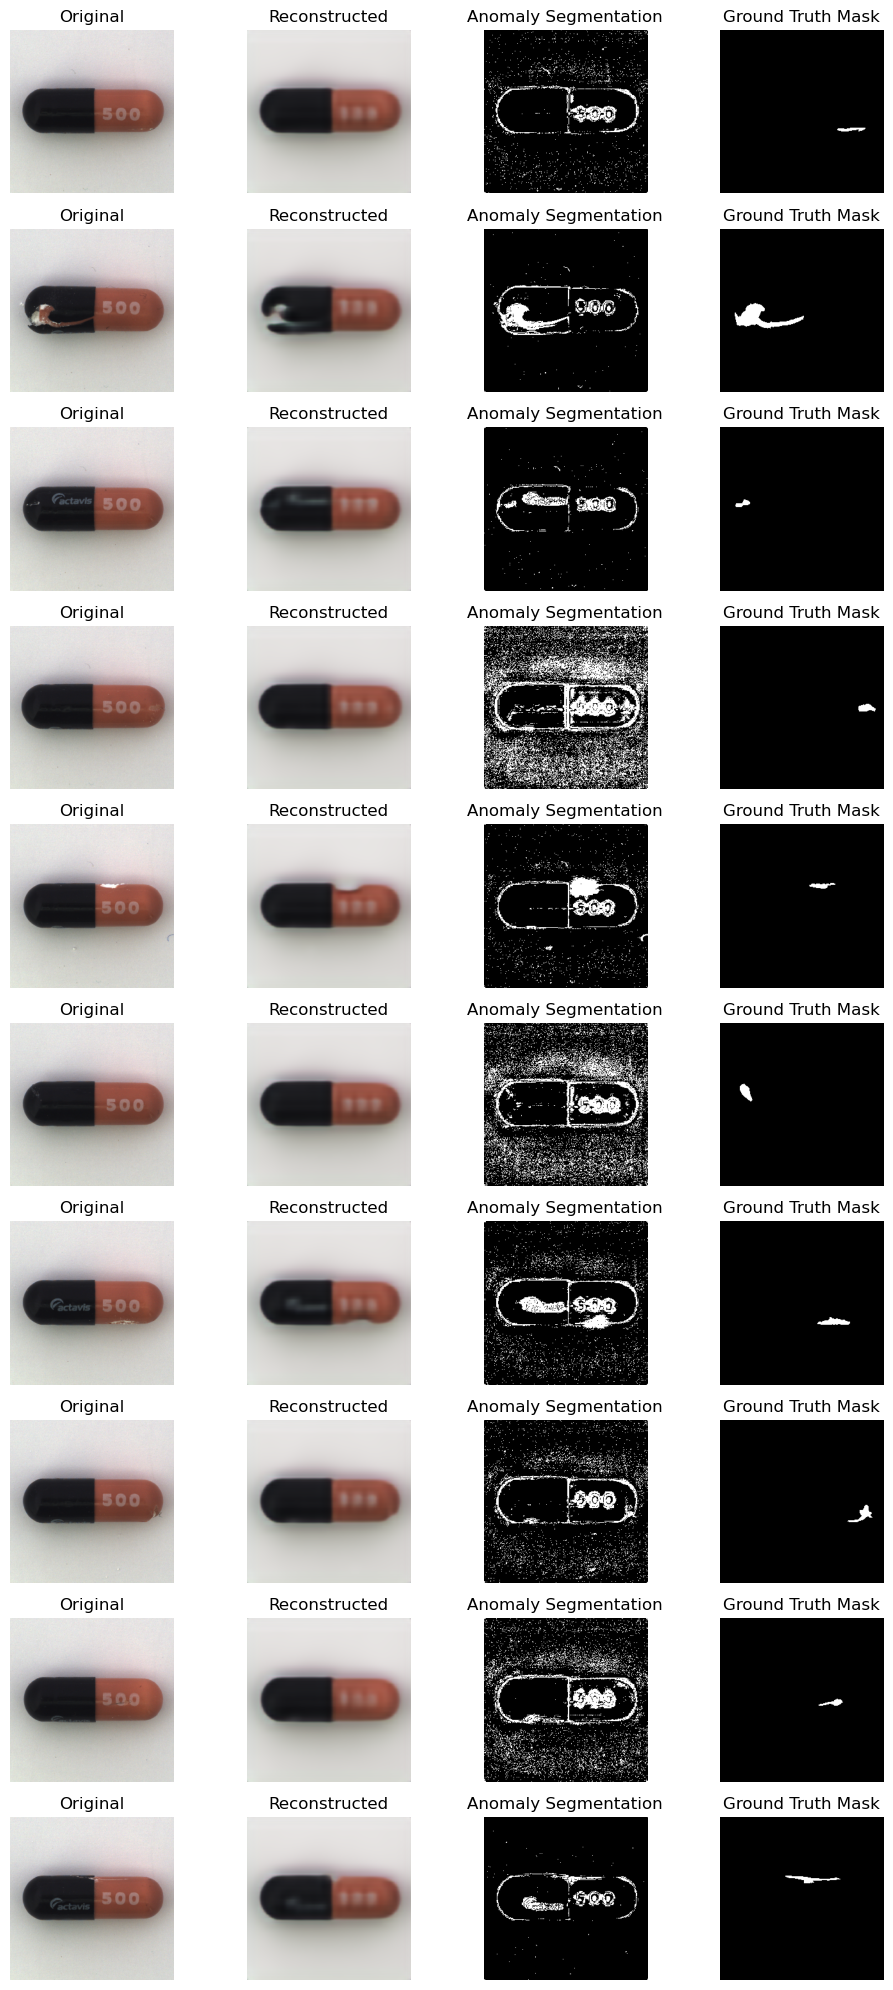

In [11]:
# --------------------------- MODEL INFERENCE --------------------------- #

import numpy as np
import cv2

def segment_anomalies(original, reconstructed, threshold=0.1):
    # Calculate the absolute difference between the original and reconstructed images
    diff = np.abs(original - reconstructed)
    
    # You might need to convert the difference to grayscale if it's not already
    diff_gray = np.mean(diff, axis=-1)  # Assuming the last dimension is color channels

    # Normalize the difference image to the range [0, 1]
    diff_gray /= np.max(diff_gray)

    # Apply threshold to get the binary mask
    anomaly_mask = diff_gray > threshold

    # Convert boolean mask to integer type (0s and 1s)
    anomaly_mask = anomaly_mask.astype(np.uint8)

    return anomaly_mask

from skimage.metrics import structural_similarity as ssim

def segment_anomalies_1(original, reconstructed):
    # Ensure the images are large enough for SSIM calculation
    if original.shape[0] < 7 or original.shape[1] < 7:
        raise ValueError("Images must be at least 7x7 pixels in size.")
    
    print(f"Shape of original: {original.shape}")
    print(f"Shape of reconstructed: {reconstructed.shape}")

    # check the data range of the images 
    print(f"Data range of original: {original.min(), original.max()}")
    print(f"Data range of reconstructed: {reconstructed.min(), reconstructed.max()}")

   # Assuming 'original' and 'reconstructed' are your images as 2D arrays (grayscale) or 3D arrays (color)
    # Calculate SSIM for each image
    ssim_map = ssim(original, reconstructed, multichannel=True, data_range=1, channel_axis=-1)

    # Compute the error map as 1 - ssim_map
    error_map = 1 - ssim_map

    # If the error_map is not 2D, reshape or slice it to make it 2D
    if error_map.ndim == 3 and error_map.shape[2] == 1:
        # If error_map is 3D with a singleton third dimension, squeeze it to 2D
        error_map = np.squeeze(error_map)
    elif error_map.ndim != 2:
        raise ValueError(f"Error map should be 2D. Got {error_map.ndim}D after SSIM calculation.")

    # Normalize the error map to [0, 255] for visualization
    error_map_normalized = (error_map * 255).astype(np.uint8)

    # Display the error map
    plt.imshow(error_map_normalized, cmap='gray')
    plt.colorbar()
    plt.title('Error Map')
    plt.show()

    # Apply Otsu's thresholding
    thresh_value, binary_mask = cv2.threshold(error_map_normalized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Display the binary mask after thresholding
    plt.imshow(binary_mask, cmap='gray')
    plt.title('Binary Mask after Thresholding')
    plt.show()

    # Visualize the error map before thresholding
    plt.imshow(error_map, cmap='gray')
    plt.colorbar()
    plt.title('Error Map')
    plt.show()

    # Apply a lower threshold or adaptive thresholding
    thresh_value, binary_mask = cv2.threshold(error_map, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # If the Otsu's threshold is making everything zero, try a manual threshold:
    # thresh_value = np.percentile(error_map, 95)  # for example, use the 95th percentile as the threshold
    # _, binary_mask = cv2.threshold(error_map, thresh_value, 255, cv2.THRESH_BINARY)

    # Make sure the error_map is a NumPy array with type float32 or uint8
    error_map = np.array(error_map, dtype=np.uint8)

    # Now use cv2.threshold
    _, binary_mask = cv2.threshold(error_map, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


    # Apply morphological operations to clean up the mask
    kernel = np.ones((3,3), np.uint8)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    return binary_mask

def segment_anomalies_1(original, reconstructed):
    # Ensure the images are large enough for SSIM calculation
    if original.shape[0] < 7 or original.shape[1] < 7:
        raise ValueError("Images must be at least 7x7 pixels in size.")
    
    # Calculate SSIM for each image
    ssim_value, ssim_map = ssim(original, reconstructed, full=True, 
                                data_range=np.max(original) - np.min(original), 
                                multichannel=True, channel_axis=-1)

    # Compute the error map as 1 - ssim_map
    error_map = 1 - ssim_map
    
    # Normalize the error map to [0, 255] for visualization
    error_map_normalized = (error_map * 255).astype(np.uint8)

    # Assuming error_map_normalized is the normalized error map, which should be a single-channel image
    if error_map_normalized.ndim == 3 and error_map_normalized.shape[-1] == 3:
        # Convert to grayscale by taking the mean across the color channels if necessary
        error_map_normalized = np.mean(error_map_normalized, axis=-1).astype(np.uint8)

    # If error_map_normalized is still 3D at this point, something is wrong with the error_map
    assert error_map_normalized.ndim == 2, "Error map normalized should be 2D"


    # Apply Otsu's thresholding to the normalized error map
    thresh_value, binary_mask = cv2.threshold(error_map_normalized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply morphological operations to clean up the mask
    kernel = np.ones((3,3), np.uint8)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    ## --
    # Apply adaptive thresholding
    binary_mask = cv2.adaptiveThreshold(
        error_map_normalized, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,
        blockSize=11,  # Block size to determine the threshold for a region
        C=2            # Constant subtracted from the mean to calculate the threshold
    )

    # Apply morphological operations
    kernel = np.ones((5,5), np.uint8)  # Increase the size if needed
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel, iterations=2)


    return binary_mask

# You would call this function for each image in your test set
# Assuming `test_images` and `reconstructed_images` are numpy arrays of your images
anomaly_segmentations = []
for original, reconstructed in zip(test_images, reconstructed_images):
    # anomaly_mask = segment_anomalies(original, reconstructed, threshold=0.2)
    anomaly_mask = segment_anomalies(original, reconstructed)
    anomaly_segmentations.append(anomaly_mask)

# Now `anomaly_segmentations` contains a binary mask for each image indicating anomalies


# plot the first 10 images in the test set along with their reconstructions and ground truth masks
# plot each of them in subplots with first image being the original image, second image being the reconstructed image, third being the anomaly segmantation image and last image being the ground truth mask

plt.subplots(10, 4, figsize=(10, 20))
for i in range(10):
    plt.subplot(10, 4, 4*i + 1)
    plt.imshow(test_images[i])
    plt.title('Original')
    plt.axis('off')

    plt.subplot(10, 4, 4*i + 2)
    plt.imshow(reconstructed_images[i])
    plt.title('Reconstructed')
    plt.axis('off')

    plt.subplot(10, 4, 4*i + 3)
    plt.imshow(anomaly_segmentations[i], cmap='gray')
    plt.title('Anomaly Segmentation')
    plt.axis('off')

    plt.subplot(10, 4, 4*i + 4)
    plt.imshow(ground_truth_masks[i], cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [10]:

from sklearn.metrics import roc_auc_score, roc_curve

# Flatten the ground truth masks and the predicted anomaly segmentation masks
ground_truth_masks_flatten = ground_truth_masks.reshape(-1)
anomaly_segmentations_flatten = anomaly_segmentations.reshape(-1)

# Calculate the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(ground_truth_masks_flatten, anomaly_segmentations_flatten)
roc_auc = roc_auc_score(ground_truth_masks_flatten, anomaly_segmentations_flatten)

print(f"Pixel-wise ROC-AUC: {roc_auc}")



AttributeError: 'list' object has no attribute 'reshape'